In [1]:
import os
from src import RASPRoutines

RASP = RASPRoutines.RASP_Routines()

In [2]:
""" the command below will re-run colocalisation analysis on already analysed data

analysis_file: an analysis file .csv

threshold: a photon threshold

protein_string: a string for images with protein in

cell_string: a string for cellular images

"""

analysis_file = os.path.abspath(
    r"example_images_analysis/spot_analysis.csv"
)  # example file, replace as you wish. Always input as the absolute path of a raw string
threshold = 1000.0
protein_string = "C1"
cell_string = "C0"

cell_punctum_analysis = RASP.count_puncta_in_individual_cells_threshold(
    analysis_file, threshold, protein_string=protein_string, cell_string=cell_string
)

In [3]:
# we can now use various plotting commands to select a z-slice and plot the cell mask vs number of puncta
import polars as pl
from src import IOFunctions

IO = IOFunctions.IO_Functions()

from src import AnalysisFunctions

A_F = AnalysisFunctions.Analysis_Functions()
import os

puncta = pl.read_csv("example_images_analysis/spot_analysis.csv")

file = cell_punctum_analysis["image_filename"][0]  # we take a file we're interested in

# now find the corresponding cell mask
mask_file = os.path.join(
    "/" + os.path.join(*file.split("/")[:-1]) + "_analysis",
    str(
        file.split("/")[-1].split(".")[0].split(protein_string)[0]
        + cell_string
        + "_cellMask.tiff"
    ),
)
# read it in
cell_mask = IO.read_tiff(mask_file)

z_plane = 15

analysis, cell_mask_toplot_AT, cell_mask_toplot_UT, cell_mask_toplot_R = (
    A_F.create_npuncta_cellmasks(cell_punctum_analysis, puncta, cell_mask, z_plane)
)

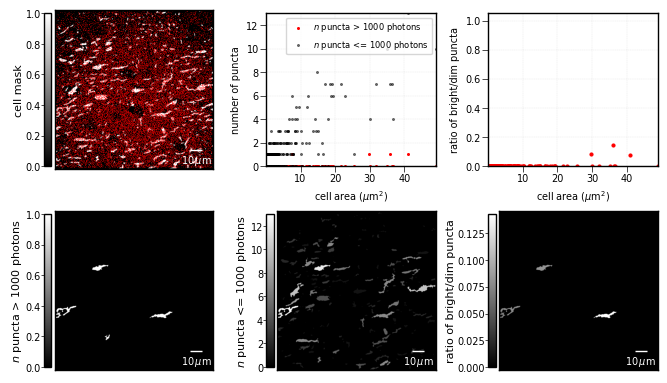

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from src import PlottingFunctions

plotter = PlottingFunctions.Plotter()

fig, axs = plotter.two_column_plot(
    ncolumns=3, nrows=2, widthratio=[1, 1, 1], heightratio=[1, 1]
)

axs[0, 0] = plotter.image_scatter_plot(
    axs=axs[0, 0],
    xdata=puncta["x"],
    ydata=puncta["y"],
    data=cell_mask[:, :, z_plane - 1],
    cbarlabel=r"cell mask",
    s=0.01,
    lws=0.25,
)

axs[0, 1] = plotter.scatter_plot(
    axs=axs[0, 1],
    x=analysis["area/pixels"].to_numpy() * (0.11**2),
    y=analysis[:, 5].to_numpy(),
    s=2,
    facecolor="red",
    edgecolor=None,
    label=r"$n$ puncta > 1000 photons",
)
axs[0, 1] = plotter.scatter_plot(
    axs=axs[0, 1],
    x=analysis["area/pixels"].to_numpy() * (0.11**2),
    y=analysis[:, 4].to_numpy(),
    s=2,
    facecolor="black",
    edgecolor=None,
    label=r"$n$ puncta <= 1000 photons",
    alpha=0.5,
    xaxislabel=r"cell area ($\mu$m$^2$)",
    yaxislabel="number of puncta",
)
axs[0, 1].legend(loc="upper right", fontsize=6)
xdiff = np.diff(axs[0, 1].get_xlim())[0]
ydiff = np.diff(axs[0, 1].get_ylim())[0]
axs[0, 1].set_aspect(0.9 * (xdiff / ydiff), adjustable="box")

y = analysis["n_puncta_in_cell_ratio_aboveandbelow"].to_numpy()
inds = np.isfinite(y)
y = y[inds]
x = analysis["area/pixels"].to_numpy()[inds] * (0.11**2)
axs[0, 2] = plotter.scatter_plot(
    axs=axs[0, 2],
    x=x,
    y=y,
    s=5,
    facecolor="red",
    edgecolor=None,
    yaxislabel="ratio of bright/dim puncta",
    xaxislabel=r"cell area ($\mu$m$^2$)",
)
axs[0, 2].set_ylim([0, 1.05])
xdiff = np.diff(axs[0, 1].get_xlim())[0]
axs[0, 2].set_aspect(0.9 * (xdiff / 1.05), adjustable="box")

axs[1, 0] = plotter.image_plot(
    axs=axs[1, 0], data=cell_mask_toplot_AT, cbarlabel=r"$n$ puncta > 1000 photons"
)
axs[1, 1] = plotter.image_plot(
    axs=axs[1, 1], data=cell_mask_toplot_UT, cbarlabel=r"$n$ puncta <= 1000 photons"
)
axs[1, 2] = plotter.image_plot(
    axs=axs[1, 2], data=cell_mask_toplot_R, cbarlabel=r"ratio of bright/dim puncta"
)

plt.tight_layout(h_pad=-15)